<span style="color:#FEA052"> 


 # ModelVerification.jl toolbox 🚀  <a href="http://icontrol.ri.cmu.edu"><img width="60" alt="portfolio_view" align="left" src="http://icontrol.ri.cmu.edu/assets/logos/icl_logo.jpg"></a>

</span>


----------------

Deep Neural Networks are crucial in approximating nonlinear functions across diverse applications, such as computer vision and control. Verifying specific input-output properties can be a highly challenging task. To this end, we present ModelVerification.jl, the only cutting-edge toolbox that contains a suite of state-of-the-art methods for verifying DNNs. This toolbox significantly extends and improves the previous version (NeuralVerification.jl) and is designed to empower developers and machine learning practitioners with robust tools for verifying and ensuring the trustworthiness of their DNN models.


<span style="color:#FBBC88"> 

### Key features: 

</span>

- <span style="text-decoration:underline">*Julia Language and Python integration*</span>:
Built on the Julia programming language, ModelVerification.jl leverages Julia's high-performance capabilities, ensuring efficient and scalable verification processes. Moreover, we provide the user with an easy-ready-to-use Python interface to exploit the full potential of the toolbox even without knowledge of the Julia language.

- <span style="text-decoration:underline">*Different types of verification*</span>:
ModelVerification.jl enables verification of several input-output specifications, such as reachability analysis, behavioral properties (e.g., to verify Deep Reinforcement Learning (DRL) policies), or even robustness properties for Convolutional Neural Networks (CNNs). It also introduces new types of verification, not only for finding individual adversarial inputs but also for enumerating the entire set of (un)safe regions for a given network and safety properties.

- <span style="text-decoration:underline">*Visualization of intermediate verification results (reachable sets)*</span>:
ModelVerification.jl enables the visualization of intermediate verification results in terms of reachable sets. In particular, our toolbox allows to plot the impactful features for the verification process and the correlated output reachable set (layer by layer) and thus to define new specific input-output specifications based on this information.

- <span style="text-decoration:underline">*Verification Benchmarks*</span>: 
Compare our or your tool implementation against state-of-the-art benchmarks and evaluation criteria (VNN comp). ModelVerification.jl includes a collection of solvers and standard benchmarks to perform this evaluation efficiently.

This tutorial briefly overviews what can be done with ModelVerification.jl. The roadmap is reported below

<span style="color:#FBBC88"> 

# Table of Contents: </span> 
- [ How does the ModelVerification.jl toolbox work? ](#id-section1)
- [ DNN-Verification instance ](#id-section2)
  - [ Creating-Loading the model ](#id-section2-1)
  - [ Safety property to verify and solver requirements](#id-section2-2)
- [ Example 1: Verifying a toy DNN with reachability analysis ](#example1)
- [ Example 2: Verifying CNNs for robustness verification](#example2)
  - [MNIST classification](#example2-1)
  - [Keypoints detection](#example2-2)
- [ Example 3: Verifying DRL policies for collision avoidance](#example3)
  - [DNN-Verification for robotic mapless navigation](#example3-1)
  - [ACAS xu benchmark](#example3-2)





<div id='id-section1'/>

# How does the ModelVerification.jl toolbox work?

-------------

<p align="center">
<img src="images_tutorial/overview.png" alt="Drawing" align="center" style="width: 800px;"/>
</p>

$$general\;overview$$

ModelVerification.jl receives as input a set consisting of: 
- Model to be verified, 
- A safety property encoded as input-output specifications for the neural network
- A search, split, and propagation method to perform the verification process. These components encode the solver.

The toolbox's output varies depending on the type of verification we are performing. Nonetheless, at the end of the verification process, the response of the toolbox potentially allows us to obtain provable guarantees that a given safety property holds (or does not) for the model tested. The possible results and their significance are reported below:

|        Output result        |  Explanation  | 
|----------------------|:-----------:|
| `BasicResult::hold`     | The input-output constraint is always satisfied | 
| `BasicResult::violated`    | The input-output constraint is violated, i.e., it exists a single point in the input constraint that violates the property         | 
| `BasicResult::timeout`    | Could not be determined if the property holds due to timeout in the computation        | 
| `CounterExampleResult`    | Like BasicResult, but also returns a counterexample if one is found (if status = :violated). The counterexample is a point in the input set that, after the NN, lies outside the output constraint set.        |
| `AdversarialResult`    | Like BasicResult, but also returns the maximum allowable disturbance in the input (if status = :violated)        |
| `ReachabilityResult`    | Like BasicResult, but also returns the output reachable set given the input constraint (if status = :violated).        |
| `EnumerationResult`    | Set of property's domain that does (not) contain violation of the safety property.        |

We refer to the interested reader to the ModelVerification.jl documentation for further details.
We report in the following box an exaplanatory overview of the ModelVerification.jl workflow.


## General flow execution of ModelVerification.jl



Let's now see all these components and how we can instantiate them in the toolbox.

<p align="center">
<img src="images_tutorial/overview_mvflow.png" alt="Drawing" align="center" style="width: 800px;"/>
</p>

$$General\;workflow\;of\;ModelVerification.jl\; toolbox$$

as mentioned above, ModelVerification.jl receives as an instance to verify a model, a safety coding property as an input-output relationship for the model, and a set of methods such as search, split, and propagation, which form the solver that the user can choose from those available in the toolbox. 

Once the instance is created, the verification begins: the main methods all solvers have in common are presented in the diagram. In particular, there is a branching phase based on the strategies chosen by the user and a subsequent searching and validation phase of these branches. The verification process can end in one of three possible states on the image's right side. Let's see how we can create all these components with realistic case studies!

<div id='id-section2'/>

# Creating the *DNN-Verification* instance

---------

A *DNN-Verification* instance consists of two main components:
- a model
- a safety property 

The model is the deep neural network we want to verify with respect to a specific safety property. A model is typically encoded as a Feed Forward Neural Network (FFNN) $\mathcal{F}$ and can be viewed graphically as follows:


<p align="center">
<img src="images_tutorial/dnn_example.png" alt="Drawing" align="center" style="width: 400px;"/>
</p>

where in the example, we have a domain for the input space $\mathcal{D}_x \in \mathbb{R}^3$ and a co-domain for the output space $\mathcal{D}_y \in \mathbb{R}^2$. Hence, $\mathcal{F}: \mathbb{R}^3 \to \mathbb{R}^2$. $\mathcal{F}$ is typically non-linear as it contains in the hidden layers non-linear activation functions, such as $ReLU$ considered in this toolbox. The safety property is encoded as an input-output relationship for $\mathcal{F}$. More specifically, considering an input constraint imposed by a set $\mathcal{X} \subseteq \mathcal{D}_x$ and an output constraint imposed by a set $\mathcal{Y} \subseteq \mathcal{D}_y$, solving the *DNN-Verification* problem (using the reachability definition) consists in showing that the following assertion holds:



$$ x \in \mathcal{X} \implies y=\mathcal{F}(x) \in \mathcal{Y} $$

A graphical representation of the reachability analysis is the following:
<p align="center">
<img src="images_tutorial/reachability.png" alt="Drawing" align="center" style="width: 400px;"/>
</p>



Due to the non-linear and non-convex nature of the DNNs, estimating the exact reachable set is unfeasible; thus, we perform an over-approximation of it, called $\mathcal{R}$. If this latter is contained in the desired reachable set, i.e., respect the constraints imposed in $\mathcal{Y}$ (as shown in the figure above), we can assert that the property holds. However, in the worst-case scenario, this problem is NP-Complete. 
In the following section, we show how it is possible to instantiate your own model and safety property and solve the *DNN-Verification* efficiently using our ModelVerification.jl toolbox.


<div id='id-section2-1'/>

## How to create/load your model

In the literature, we find various ways and formats to save a model-DNN. The most widely used being the .nnet, onnx, h5/pb format of Keras(TensorFlow), or even .pt of PyTorch. ModelVerification.jl accepts any extension and converts the input model for you first to .onnx format and then to .flux to achieve efficient performance for the verification process.  To convert your input model to .onnx, use one of the Python scripts in the "NNet/converters/" folder. Once the chosen script generates the .onnx model, it will automatically test the conversion for you.

<p align="center">
<img src="images_tutorial/model_conversion.png" alt="Drawing" align="center" style="width: 600px;"/>
</p>

<div id='id-section2-2'/>

## Safety property and solver requirements

A safety property is essentially an input-output relationship for the model we want to verify. In general, the constraints for the input set $\mathcal{X}$ and the one for the output set $\mathcal{Y}$ can have any geometry. For the sake of simplicity, ModelVerification.jl, considers convex polytopes (or the complement of a polytope) geometries to encode the input and output specifications. More specifically, our implementations exploit the geometric definitions of **LazySets.jl**, a Julia package for calculus with convex sets.

Different solvers implemented in ModelVerification.jl require the input-output specification formulated with particular geometries.
We report here a brief overview of the sets we use, and we refer to the ModelVerification.jl documentation for a complete list and more detailed information. 

 - HR = `Hyperrectangle`
 - HS = `HalfSpace`
 - HP = `HPolytope`
 - SS = `StarSet`
 - IS = `ImageStar`
 - ZT = `Zonotope`
 - PC = `PolytopeComplement`
 - CH = `ConvexHull`


|        Solver        |  Input set  |    Output     |
|----------------------|:-----------:|:----------------:|
| *Ai2*       | `ZT,SS,HP,HR` | `ReachabilityResult`, `CounterExampleResult`  |
| *CROWN*    | `ZT,SS,HP,HR,CH`          |  `BasicResult`    |
| *$\alpha$-CROWN*    | `ZT,SS,HP,HR,CH`         |  `BasicResult`      |
| *$\beta$-CROWN*    | `ZT,SS,HP,HR,CH`         |  `BasicResult`      |
| *$\alpha$-$\beta$-CROWN*   | `ZT,SS,HP,HR,CH`         |  `BasicResult`      |
| *ImageZono* | `CH` |`ReachabilityResult`, `CounterExampleResult` |
| *ImageStar* | `CH` |`ReachabilityResult`, `CounterExampleResult` |



Note that solvers that require `Hyperrectangles` also work on `HPolytopes` by overapproximating the input set. This is likewise true for solvers that require `HPolytopes` to convert a `Hyperrectangle` input to H-representation. Any set which can be made into the required set is converted, wrapped, or approximated appropriately.


<div id='example1'/>

# Example 1: Verifying a toy DNN with reachability analysis

--------

Let's warm up on the *DNN-Verification* problem with this simple DNN and safety property to verify. We consider the following DNN called "small_nnet":

<p align="center">
<img src="images_tutorial/toyDNN.png" alt="Drawing" align="center" style="width: 600px;"/>
</p>

The model has a single input node, two hidden layers composed of two ReLU nodes, and a single output node. Hence this DNN is a non-linear function that maps $\mathbb{R}^1 \to \mathbb{R}^1$. Suppose we want to verify if all the possible inputs in a vector that assume values between $\mathcal{X}=[-2.5, 2.5]$ are mapped in the vector $\mathcal{Y}=[18.5, 114.5]$. 



Given the continuous nature of the interval, we cannot test every single input in $\mathcal{X}$. Hence, we exploit the formal verification results obtained through the reachability analysis to get a provable answer to this simple specification.



First, let's load the model and encode the safety property using convex sets.

In [1]:
# let's import some necessary julia packages (will require about 1 min the first time)
include("utils_tutorial.jl")

┌ Info: Installing Julia nodeps kernelspec in /home/lmarza/.local/share/jupyter/kernels/julia-nodeps-1.9
└ @ IJulia /home/lmarza/.julia/packages/IJulia/Vo51o/deps/kspec.jl:105


keypoint_error_spec (generic function with 1 method)

Before diving into the verification process, we can play with the model and the safety property. Let's, for instance, check the architecture of the model we are going to verify:

In [2]:
# let's indicate the path of our model and call the function provided in ModelVerification to build a flux model
onnx_path = "models/small_nnet.onnx"
toy_model = ModelVerification.build_flux_model(onnx_path)

Chain(
  Dense(1 => 2, relu),                  # 4 parameters
  Dense(2 => 2, relu),                  # 6 parameters
  Dense(2 => 1, relu),                  # 3 parameters
)                   # Total: 6 arrays, 13 parameters, 488 bytes.

As we can notice, ModelVerification.jl converted the .onnx into a Flux model, as indicated above. The structure is the same as depicted in the figure above, where we have an input layer with two hidden layers activated with ReLU and an output layer activated with ReLU as well. The parameters are the # of weights and biases of each layer. 

Let's now plot the result of a forward propagation of different inputs for our toy_model

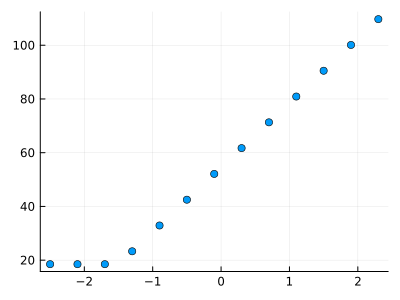

In [3]:
# Create sample input data
domain = -2.5:0.4:2.5 

# Perform forward propagation and plot the result
y = [toy_model([x])[1] for x in domain]
scatter(domain, y)

We can now encode the required property and attempt to falsify it using different algorithms of *DNN-Verification*. First of all, we can declare the two sets of interest and construct a *Problem* instance for the ModelVerification.jl toolbox. Then we can use any algorithm in the library (that supports Hyperrectangles in this case) to test the property.

In [4]:
# let's define the input-output specification to be verified
X = Hyperrectangle(low = [-2.5], high = [2.5]) # expected out: [18.5, 114.5]
Y = Hyperrectangle(low = [18.5], high = [114.5]) # here we check if the property holds


# let's instantiate the Problem for the ModelVerification.jl toolbox
problem = Problem(toy_model, X, Y)
problem.Flux_model

Chain(
  Dense(1 => 2, relu),                  # 4 parameters
  Dense(2 => 2, relu),                  # 6 parameters
  Dense(2 => 1, relu),                  # 3 parameters
)                   # Total: 6 arrays, 13 parameters, 488 bytes.

Clearly, this network is elementary, and any property can be verified by hand, but we will continue with the example! Let's now instantiate the solver, in this case, *Ai2*, and check the formal result of the verification process. As indicated in the workflow shown above ModelVerification.jl requires a search, a split, and a propagation method in addition to the DNN and the input-output specification.  

In [5]:
# we instantiate the 3 main components for the verification process
search_method = BFS(max_iter=100, batch_size=1)
split_method = Bisect(1)
solver = Ai2()

Ai2z()

In [7]:
# we then start the verification process using the verify function of ModelVerification.jl
result = verify(search_method, split_method, solver, problem)

# the verification result is stored in 'result'. Let's print it!
println("The result is: ", result)

# the verification result is stored in 'result.status'. Let's see if the property holds...
println("The property ", result.status, "!")


The result is: BasicResult(:holds)
The property holds!


The first print produces the type of result returned by *Ai2*, i.e., `BasicResult`. We can notice that inside the rounded brackets, we can already see the output of the verification process. To get access to the value, we can do `result.status`. *Ai2* states that the input-output relationship holds, i.e., every possible input $x \in \mathcal{X}$ is actually mapped in the reachable set $\mathcal{Y} = [18.5, 114.5]$.

Let's see if using another solver we have the same result:

In [8]:
# we instantiate the 3 main components for the verification process
search_method = BFS(max_iter=100, batch_size=1)
split_method = Bisect(1)

# parameter used in CROWN
use_gpu = false
lower_bound = true
upper_bound = true

solver = Crown(use_gpu, lower_bound, upper_bound)

# we then start the verification process using the verify function of ModelVerification.jl
result = verify(search_method, split_method, solver, problem)

# the verification result is stored in 'result'. Let's print it!
println("The result is: ", result)

# the verification result is stored in 'result.status'. Let's see if the property holds...
println("The property ", result.status)

The result is: BasicResult(:holds)
The property holds


As expected we obtain the same result!

We can now check if we obtain a different result by changing the desired output reachable set. The previous verification process told us that for the DNN $\mathcal{F}$, all the values in the domain $[-2.5, 2.5]$ are mapped in $[18.5, 114.5]$. Hence, we can test if we obtain a violation by modifying the output reachable set. More specifically, suppose to check if starting from $\mathcal{X}=[-2.5, 2.5]$ all the values are mapped in $\mathcal{Y}=[20, 114]$.

In [9]:
# let's define the input-output specification to be verified
X = Hyperrectangle(low = [-2.5], high = [2.5]) # expected out: [18.5, 114.5]
Y = Hyperrectangle(low = [20], high = [114]) # here we expect the property is violated


# let's instantiate the Problem for the ModelVerification.jl toolbox
problem = Problem(onnx_path, X, Y)

# we instantiate the 3 main components for the verification process
search_method = BFS(max_iter=100, batch_size=1)
split_method = Bisect(1)

solver = Ai2()
result = verify(search_method, split_method, solver, problem)


# the verification result is stored in 'result.status'. Let's see if the property holds...
println("The property is ", result.status, "!")
println("A counterexample is ", result.info["counter_example"])

The property is violated!
A counterexample is 

[-1.875]


As expected, we obtained a `result.status=violated`, meaning this property does not hold for all values in $\mathcal{X}$. Even though the interval $[20, 114] \subset [18.5, 114.5]$, this does not imply that all the values in $\mathcal{X}$ are mapped in the smaller subset $[20, 114]$. Infact, as shown even in the plot above, if we compute $\mathcal{F}(counterexample)$ we obtain

In [10]:
counter_example = result.info["counter_example"]
println("Test propagation $(counter_example)...")
y = toy_model(counter_example)[1]
println("The output is: ", y)
print("$y < 20? ", y<20)

Test propagation [-1.875]...
The output is: 18.5


18.5 < 20? true

### Different type of verification strategies

We've just seen the reachability analysis, but ModelVerification.jl allowed us to use Optimization-based methods that encode, convexifying the non-linear activation function, the relations in the network as an optimization problem.

In most of these strategies, as well as in the verification process, rather than checking if the output is in $\mathcal{Y}$, the optimization/feasibility problem checks if the result is not in the complement of the set, i.e., $\mathcal{Y}_c$. Broadly speaking, following the example above, instead of looking at the output reachable set in $[18.5, 114.5]$, we can check if the output can be less than $18.5$ or greater than $114.5$.

Let's see how we can make this check. We can still use CROWN as a solver, since it supports Complement sets as input-output specifications.

In [11]:
# let's define the input-output specification to be verified
X = Hyperrectangle(low = [-2.5], high = [2.5]) # expected out: [18.5, 114.5]
Y_c = Complement(Hyperrectangle(low = [18.5], high = [114.5])) # y ≤ 18.5 or y ≥ 114.5


# let's instantiate the Problem for the ModelVerification.jl toolbox
problem = Problem(onnx_path, X, Y_c)

# we instantiate the 3 main components for the verification process
search_method = BFS(max_iter=150, batch_size=1)
split_method = Bisect(1)

# parameter used in CROWN
use_gpu = false
lower_bound = true
upper_bound = true
solver = Crown(use_gpu, lower_bound, upper_bound)
result = verify(search_method, split_method, solver, problem)


# the verification result is stored in 'result.status'. Let's see if the property holds...
println("The property is ", result.status, "!")

The property is violated!


As expected, we obtained a `violated` answer, meaning that if the output cannot be below $18.5$ or above $114.5$, it should necessarily be contained in $[18.5, 114.5]$. Nonetheless, checking an output reachable set's complement cannot always be helpful. Suppose we verify this condition  

In [12]:
# let's define the input-output specification to be verified
X = Hyperrectangle(low = [-2.5], high = [2.5]) # expected out: [18.5, 114.5]
Y_c = Complement(Hyperrectangle(low = [115], high = [118.5])) # y ≤ 115 or y ≥ 118.5


# let's instantiate the Problem for the ModelVerification.jl toolbox
problem = Problem(onnx_path, X, Y_c)

# we instantiate the 3 main components for the verification process
search_method = BFS(max_iter=100, batch_size=1)
split_method = Bisect(1)

# parameter used in CROWN
use_gpu = false
lower_bound = true
upper_bound = true
solver = Crown(use_gpu, lower_bound, upper_bound)
result = verify(search_method, split_method, solver, problem)


# the verification result is stored in 'result.status'. Let's see if the property holds...
println("The property ", result.status, "!")

The property holds!


As we notice, we have a `holds` answer. In fact, the output can assume values below $115$ (we recall that the output reachable set is $[18.5,114,5]$). However, with this verification query, we only know that the output reachable set is all less than $115$ or greater than $118.5$. 

<div id='example2'/>

# Example 2: Verifying CNNs for robustness verification

In this section, we will see how it is possible to use ModelVerification.jl to perform robustness verification. Before diving into the verification process, let's recall the robustness DNN-Verification definition. To verify robustness in a classification network, we need to ensure that given a possible perturbation of a given input $x_0$, all samples in the neighborhood of this perturbation are classified with the same desired label. 

In particular, let's suppose we have ten numerical digits; thus, the network outputs ten possible values, each representing a label for the input image. Hence, given a particular input image, we want to provably verify that for a possible $\epsilon$-perturbance of this input image, the CNN always outputs the desired label $i^*$ corresponding to the input image (i.e., ensure that $y_{i^*} > y_j\; \forall j \neq i^*$). Formally: 

$$\mathcal{X} = \{x: \vert\vert x-x_0 \vert\vert_p \leq \epsilon \} $$
$$\mathcal{Y} = \{y: y_{i^*}>y_j,\; \forall j \neq i^* \} $$



Typically, the metric to measure disturbance $p$, can be any $l_p$ norm, though the $l_{\infty}$ or the $l_1$ norms are common because they lead to linear constraints.

<div id='example2-1'/>

## MNINST case study

Let's now move to the real example of this section. Specifically, we will inspect networks trained to classify hand-written digits from the MNIST dataset. 
This latter is composed of handwritten digits, as shown below. Each sample is a grayscale image (with a single 8 bit channel) of 28 x 28 pixels.


<p align="center">
<img src="images_tutorial/mnistexamples.png" alt="Drawing" align="center" style="width: 800px;"/>
</p>




We will load a pretrained network and then verify it to find an adversarial example - an input point close to an original training point that produces undesirable output, such as a misclassification error.

In [13]:
model = Chain(
    Conv((5, 5), 1=>6, relu),
    MeanPool((2, 2)),
    Conv((5, 5), 6=>16, relu),
    MeanPool((2, 2)),
    Flux.flatten,
    Dense(256 => 120, relu),
    Dense(120 => 84, relu), 
    Dense(84 => 10),
)
loaded_state = JLD2.load("models/lenet.jld2", "lenet_state");
Flux.loadmodel!(model, loaded_state)

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MeanPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MeanPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

Let's now consider a particular image of the dataset to verify... For a better visualization of the possible values each pixel can take we use a heatmap to display the original input for our CNN: 

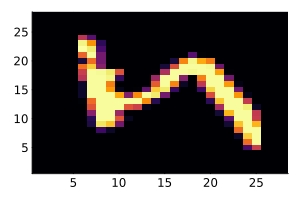

Image size: (28, 28)


In [14]:
img = MNIST(:train)[1].features
println("Image size: ", size(img))

# create a heatmap for a better visualization
p1 = heatmap(img)
label = MNIST(:train)[1].targets
display(plot(p1, size=(300,200)))

As we can see, we have a 28x28 image of the digit "5." Each pixel can take a value between $[0,1]$, where $0$ represents the color black and $1$ represents white. Let's now perturb this image. The idea is to place a white patch in a specific image zone and then use a convex hull to create an interpolation between the original image and the perturbated one.

Let's now create the perturbation

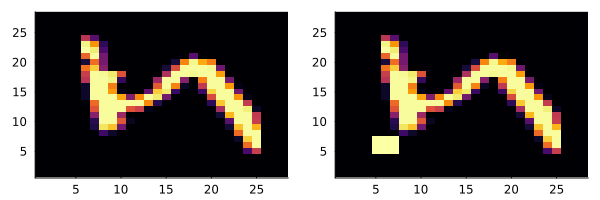

In [15]:
# create a copy of the original image
img_blocked = copy(img)

# assign to a specific zone of the image a square of white pixels
img_blocked[5:7,5:7] .= 1
p2 = heatmap(img_blocked)
display(plot(p1, p2, layout=(1,2), size=(600,200)))

Now let's create the instance for the robustness verification:

In [16]:
# first we flatten the matrix in one vector of 784 inputs
img = reshape(img, (28,28,1))

# similarly for the perturbated img
img_blocked = reshape(img_blocked, (28,28,1))

# now we create the image convex hull
input_set = ImageConvexHull([img, img_blocked])
output_set = classification_spec(10, label+1) # label start from 0

HPolyhedron{Float64, Vector{Float64}}(HalfSpace{Float64, Vector{Float64}}[HalfSpace{Float64, Vector{Float64}}([1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0], 0.0)])

And run the verification process using $ImageZono$ as a solver provided in ModelVerification.jl

In [17]:
search_method = BFS(max_iter=1, batch_size=1)
split_method = Bisect(1)
println("The property: ", verify(search_method, split_method, ImageZono(), Problem(model, input_set, output_set)).status)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((5, 5), 1 => 6)
│   summary(x) = 28×28×1×1 Array{Float64, 4}
└ @ Flux /home/lmarza/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


CUDA.OutOfGPUMemoryError: Out of GPU memory trying to allocate 600 bytes
Effective GPU memory usage: 99.81% (15.710 GiB/15.740 GiB)
Memory pool usage: 0 bytes (0 bytes reserved)


ModelVerification.jl also allows to visualize the output reachable sets of each layer during the verification process:

In [ ]:
visualize(search_method, split_method, ImageZono(), Problem(model, input_set, output_set), "visualization_RS/")

Let's analyze a couple of output images obtained...

<p align="center">
<img src="visualization_RS/1_conv_0.png" alt="Drawing" align="center" style="width: 800px;"/>
</p>


In the left part of the image we can notice the center of the reachable set, while on the right the bound size.

Let's now see the output reachable set: 

<p align="center">
<img src="visualization_RS/12_dense_2.png" alt="Drawing" align="center" style="width: 800px;"/>
</p>

As we notice on the left we have that for the value 5 we have an associate maximum value in the heatmap, that's why the CNN predicted label "5"!

<div id='example2-2'/>

## Keypoints detection

In this second example, we consider the *keypoints detection* task. In particular, given a CNN and a set of keypoints in the image, the model is robust if it can always precisely spot the location of each keypoint in the image, no matter the possible perturbation of the image.
ModelVerfication.jl allows us to compute this formal analysis, providing several solvers and useful tools to analyze the results of this computation.


For this section, let's consider a realistic scenario where, given a set of keypoints provided in a .csv file, we want to check if a particular model is formally robust to possible different perturbation of the model.

In [ ]:
include("utils_tutorial.jl")

First of all, we load the pretrained model. The originally trained networks for this specific task output heatmaps where the last layer has a softmax activation to identify the argmax corresponding to a specific label to be compared with the ground truth expected keypoint position. However, verifying a network that uses heatmaps as output and, more specifically, with a softmax layer is complicated. 

For this reason, ModelVerification.jl provides an automatic converter of this model into a model where the last layer is replaced with a layer average pooling and transform the verification into a classification problem. 

In [18]:
# let's build our flux model
onnx_model_path = "./models/boeing_model.onnx"
model = build_boeing_flux_model(onnx_model_path)
testmode!(model);

println(model)

Chain(Conv((7, 7), 3 => 64, pad=3, stride=2, bias=false), BatchNorm(64

, relu, active=false), MeanPool((3, 3), pad=1, stride=2), 

SkipConnection(Chain(Conv((3, 3), 64 => 64, pad=1, bias=false), BatchNorm(64, relu, active=false), Conv((3, 3), 64 => 64, pad=1, bias=false), BatchNorm(64, active=false)), 

+), #217, SkipConnection(Chain(Conv((3, 3), 64 => 64, pad=1, bias=false), BatchNorm(64, relu, active=false), Conv((3, 3), 64 => 64, pad=1, bias=false), BatchNorm(64, active=false)), +), #217, Parallel(+, α = Chain(Conv((3, 3), 64 => 128, pad=1, stride=2, bias=false), BatchNorm(128, relu, active=false), Conv((3, 3), 128 => 128, pad=1, bias=false), BatchNorm(128, active=false))

, β = Chain(Conv((1, 1), 64 => 128, stride=2, bias=false), BatchNorm(128, active=false))), #217, SkipConnection(Chain(Conv((3, 3), 128 => 128, pad=1, bias=false), BatchNorm(128, relu, active=false), Conv((3, 3), 128 => 128, pad=1, bias=false), BatchNorm(128, active=false)), +), #217, Parallel(+, α = Chain(Conv((3, 3), 128 => 256, pad=1, stride=2, bias=false), BatchNorm(256, relu, active=false), Conv((3, 3), 256 => 256, pad=1, bias=false), BatchNorm(256, active=false)), β = Chain(Conv((1, 1), 128 => 256, stride=2, bias=false), BatchNorm(256, active=false))), #217, SkipConnection(Chain(Conv((3, 3), 256 => 256, pad=1, bias=false), BatchNorm(256, relu, active=false), Conv((3, 3), 256 => 256, pad=1, bias=false), BatchNorm(256, active=false)), +), #217, Parallel(+, α = Chain(Conv((3, 3), 256 => 512, pad=1, stride=2, bias=false), BatchNorm(512, relu, active=false), Conv((3, 3), 512 => 512, pad=1, bias=false), BatchNorm(512, active=false)), β = Chain(Conv((1, 1), 256 => 512, stride=2, bias=fal

That is, as in the previous case of MNIST, the network is robust if given a possible perturbation of the image, the network output corresponding to the keypoint position in the image itself continues to be correct. 

Graphically we perform the following:

<p align="center">
<img src="images_tutorial/robustness_pipeline.png" alt="Drawing" align="center" style="width: 1000px;"/>
</p>

In [19]:
# the csv contains keypoints (the labels)
img_path = "./images_tutorial/AircraftInspection_00000008.png"
csv_path = "./csv_file_keypoints/SynthPlane_08.csv"
input = load_image(img_path, csv_path);

In [20]:
# load the image without background
img_path = "./images_tutorial/AircraftInspection_bg_00000008.png"
csv_path = "./csv_file_keypoints/SynthPlane_08.csv"
input_bg = load_image(img_path, csv_path);

In [21]:
# generate a image with block occulusion
input = reshape(input, 256, 256, 3)
input_bg = reshape(input_bg, 256, 256, 3)
input_perturbed = copy(input)

input_perturbed[100,100,2,1] = -0.5
# input_perturbed[100,100,1:3,1] .= -0.5
#input_perturbed[100:101,100:101,1:3,1] .= -0.5
#input_perturbed[100:130,130:160,1:3,1] .= -0.5;

-0.5

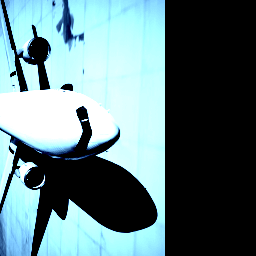

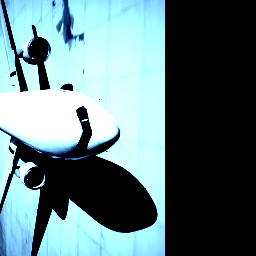

In [22]:
# use the block occulusion to builc image convex hull
# input_adv = input_bg;
input_adv = input_perturbed;
display(colorview(RGB, permutedims(input[:, :, :, 1], [3,1,2])))
display(colorview(RGB, permutedims(input_adv[:, :, :, 1], [3,1,2])))
# colorview(RGB, img)

As we can notice we created a perturbation of the image, adding a small red patch in the center of the second image...

In [23]:
# show the prediction of the original image and the perturbed image
y = model(reshape(input, 256,256,3,1))
y_adv = model(reshape(input_adv, 256,256,3,1))
keypoint_loc = [x[1] for x in argmax(reshape(y, 64, 24), dims=1)]
keypoint_loc_adv = [x[1] for x in argmax(reshape(y, 64, 24), dims=1)]
println(keypoint_loc')
println(keypoint_loc_adv')

[12; 13; 21; 20; 29; 21; 6; 20; 21; 20; 21; 20; 21; 2; 14; 10; 14; 5; 5; 3; 3; 2; 4; 4;;]
[12; 13; 21; 20; 29; 21; 6; 20; 21; 20; 21; 20; 21; 2; 14; 10; 14; 5; 5; 3; 3; 2; 4; 4;;]


In [ ]:
keypoint_spec = keypoint_error_spec(y, keypoint_loc, 64)

# Verify the problem. It takes about 1-3 mins.
pre_slit = 256
max_iter = pre_slit * 2
search_method = BFS(max_iter=max_iter, batch_size=1)
split_method = Bisect(1)
prop_method = ImageZono()
image_seeds = ImageConvexHull([input, input_adv])  # 256 x 256 x 3 x 2
stats = @timed verify(search_method, split_method, prop_method, Problem(model, image_seeds, keypoint_spec), pre_split=pre_slit)


As we have done with the MNIST case study we can visualize each layer reachable set...

In [ ]:
# Visualize the reachable set of the first propagation
search_method = BFS(max_iter=1, batch_size=1)
split_method = Bisect(1)
prop_method = ImageZono()
visualize(search_method, split_method, prop_method, Problem(model, image_seeds, keypoint_spec), "visualization_RS_keypoints/")

<div id='example3'/>

# Example 3: Verifying a DRL policy for collision avoidance safety property

-----

This section shows how we can use ModelVerification.jl to verify DRL policies or behavior properties more generally. We begin with a robotic mapless navigation task and then the ACAS xu benchmark.

<div id='example3-1'/>

## DNN-Verification for robotic mapless navigation

**Robotic mapless Navigation** is a well-known benchmark in practical DRL applications, where a robot has to learn how to navigate toward different random targets with only local information such as using a lidar (i.e., without a map of the environment).

<p align="center">
<img src="images_tutorial/mapless_navigation.gif" width="800" height="250" />

$$Robotic\;mapless\;navigation$$
<p/>

What makes this task difficult is that the only information used by the intelligent agent is based on these lidar sensors that may be subject to "noise." In particular, it is widely known that DNNs can have significantly different outputs for small perturbations in their inputs. This unexpected behavior of DNNs is likely to result in unsafe systems:

<p align="center">
<img src="images_tutorial/collision.gif" width="600" height="350" />

$$unsafe\;behavior$$
<p/>

Hence, we need the formal verification of neural networks to provide provable guarantees about the behavior of neural networks in every possible context. We begin by seeing how a neural network employed for a robotic navigation task can be verified. In particular we assume a setup similar to the following:

<p align="center">
<img src="images_tutorial/drl_collision.png" alt="Drawing" align="center" style="width: 800px;"/>
</p>

We have DNN that encodes our agent. The input space of our DNN is composed by seven continuous value that encodes using $\mathcal{D}_x = \{x_0, \dots, x_{6}\}$ , where the first five values are the lidar values that sense the distance from obstacles in the environment, while $x_{5}, x_{6}$ encode the relative position of the goal with respect to the agent's position (i.e., distance and heading). Regarding the output space, for the sake of simplicity, we consider only three discrete actions: $y_0$ that encodes a forward movement, while $y_1, y_2$ represents a left and right rotation, respectively. 

<p align="center">
<img src="images_tutorial/dnn_drl.png" alt="Drawing" align="center" style="width: 500px;"/>
</p>


Now, suppose we want to formally verify that in the situation depicted in the center of the figure above, i.e., a situation where the agent is very close to an obstacle, the DNN never selects the action $y_0$ which will lead to a collision as represented in the right part of the figure. Hence, we are trying to encode the following situation:

<p align="center">
<img src="images_tutorial/unsafe_reg.png" alt="Drawing" align="center" style="width: 300px;"/>
</p>

$$ \forall x_i \in \mathcal{X},\quad y_0 < y_1, y_2$$

For every possible lidar value in the unsafe region encoded by $\mathcal{X}$, the action $y_0$ should always less preferred with respect to the other two available. The formal verification process consists of finding (if it exists) an assignment for $[x_0,....,x_6]^T$ such that $y_0 > y_1$ and simultaneously $y_0 > y_2$. If this assignment exists, we have a violation point in the input safety property's domain $\mathcal{X}$. On the other hand, we can assert that in that particular situation depicted in the figure above, we have provable guarantees that the agent will never select the action corresponding to a forward movement. Hence, the DNN-Verification process in this situation would require verifying the conjunction of two postconditions, which is often complicated to perform. Let's how the network structure can be modified so that the verification process can be brought back to a single condition check using halfspaces.


First let's load the original DRL model

In [ ]:
include("utils_tutorial.jl")

In [28]:
# First, let's load the model
onnx_path = "models/model_drl_unsafe.onnx"
model_drl = ModelVerification.build_flux_model(onnx_path)
model_drl

Chain(
  Dense(7 => 32; bias=false),           # 224 parameters
  ONNXNaiveNASflux.var"#217#229"{typeof(relu)}(NNlib.relu),
  Dense(32 => 32; bias=false),          # 1_024 parameters
  ONNXNaiveNASflux.var"#217#229"{typeof(relu)}(NNlib.relu),
  Dense(32 => 3; bias=false),           # 96 parameters
)                   # Total: 3 arrays, 1_344 parameters, 5.508 KiB.

As we can notice, the structure is the same as the one depicted above. Let's now perform a forward propagation to check that everything is correct

In [29]:
println("\nTest propagation:")
output_negative_original = model_drl([0.60014254, 0.02140923, 0.03877764, 0.0176078,  0.51737836, 0.80594596, 0.74477811]) # expected output [ 0.14630161 -0.1948066  -0.2447444 ]
output_size = size(output_negative_original)[1]
println(output_negative_original)

output_positive_original = model_drl([0.80014254, 0.7140923, 0.9877764, 0.776078,  0.11737836, 0.10594596, 0.04477811]) # expected output [-0.0060760486, 0.01549258, -0.092668965]
println(output_positive_original)


Test propagation:


Float32[0.14630161, -0.1948066, -0.2447444]
Float32[-0.0060760486, 0.01549258, -0.092668965]


We now modify the network structure to obtain one output node on which we can control a single condition using halfspace. In particular, the idea is to get a result equal to $0$ only if the action $y_0$ is chosen (i.e., iff $y_0 > y_1$ and $y_0 >y_2$), and a positive output in all other cases. To this end, we add a new layer activated with $ReLU$ that computes the operation $y_1 - y_0$ and $y_2 - y_0$ in the two nodes. The only possibility to obtain a negative value in both nodes is that $y_0 > y_1$ and $y_0 >y_2$. Since these nodes are activated with $ReLU$, the final output will be $0$. On the other hand, if one between $y_1$ and $y_2$ (or both) is larger than $y_0$, we will obtain a result strictly > $0$ as we want. We report a graphic representation of the transformation below:

<p align="center">
<img src="images_tutorial/dnn_conversion.png" alt="Drawing" align="center" style="width: 600px;"/>
</p>

Let's see how we can obtain this new model in Julia

In [30]:
# first we create a new layer that takes the previous original output size and output a single value
y = Dense(output_size, output_size-1)
y_final = Dense(output_size-1,1)
model_drl_new = Chain(model_drl.layers..., y, relu, y_final)
model_drl_new

Chain(
  Dense(7 => 32; bias=false),           # 224 parameters
  ONNXNaiveNASflux.var"#217#229"{typeof(relu)}(NNlib.relu),
  Dense(32 => 32; bias=false),          # 1_024 parameters
  ONNXNaiveNASflux.var"#217#229"{typeof(relu)}(NNlib.relu),
  Dense(32 => 3; bias=false),           # 96 parameters
  Dense(3 => 2),                        # 8 parameters
  NNlib.relu,
  Dense(2 => 1),                        # 3 parameters
)                   # Total: 7 arrays, 1_355 parameters, 5.801 KiB.

In [31]:
last_layer = lastindex(model_drl_new.layers) - 2
println("Original weights new layer")
println(Flux.params(model_drl_new.layers[last_layer]))


custom_weights = [-1 1 0; 
                  -1 0 1]


Flux.params(model_drl_new.layers[last_layer])[1] .= custom_weights
println("\nNew weights last layer")
println(Flux.params(model_drl_new.layers[last_layer]))

Original weights new layer
Params([Float32

[-0.28672165 0.8929369 0.8394273; 0.21611692 -0.96519876 -0.289418], Float32[0.0, 0.0]])

New weights last layer


Params([Float32[-1.0 1.0 0.0; -1.0 0.0 1.0], Float32[0.0, 0.0]])


In [32]:
last_layer = lastindex(model_drl_new.layers)
println("Original weights new layer")
println(Flux.params(model_drl_new.layers[last_layer]))

custom_weights =  reshape([1.0, 1.0], 1, 2)

Flux.params(model_drl_new.layers[last_layer])[1] .= custom_weights
println("\nNew weights last layer")
println(Flux.params(model_drl_new.layers[last_layer]))

Original weights new layer
Params([Float32[-1.287309 -1.410009], Float32[0.0]])



New weights last layer
Params([Float32[1.0 1.0], Float32[0.0]])


Let's test the conversion with the new output layer. 

In [33]:
input_negative = [0.60014254, 0.02140923, 0.03877764, 0.0176078,  0.51737836, 0.80594596, 0.74477811]
test_negative = model_drl_new(input_negative)
println("The original output for the input ", input_negative, " was")
println(output_negative_original)
println("action chosen: y_", argmax(output_negative_original)-1)
println("Output in the new DNN with new output: ",test_negative )
println()

input_positive = [0.80014254, 0.7140923, 0.9877764, 0.776078,  0.11737836, 0.10594596, 0.04477811]
test_positive = model_drl_new(input_positive)
println("The original output for the input ", input_positive, " was")
println(output_positive_original)
println("action chosen: y_", argmax(output_positive_original)-1)
println("Output in the new DNN with new output: ",test_positive )
println()


The original output for the input [0.60014254, 0.02140923, 0.03877764, 0.0176078, 0.51737836, 0.80594596, 0.74477811] was
Float32[0.14630161, -0.1948066, -0.2447444]
action chosen: y_0
Output in the new DNN with new output: 

Float32[0.0]

The original output for the input [0.80014254, 0.7140923, 0.9877764, 0.776078, 0.11737836, 0.10594596, 0.04477811] was
Float32[-0.0060760486, 0.01549258, -0.092668965]
action chosen: y_1
Output in the new DNN with new output: Float32[0.021568628]



As expected, we obtain a value equal to $0$ if the action $y_0$ is chosen in the original DNN, strictly $> 0$ otherwise. Hence, the conversion is correct! Let's now move on to encode the safety property and to the verification process.

In [49]:
# let's define the input-output specification to be verified
X = Hyperrectangle(low = [0.06, 0.01, 0.01, 0.01, 0.06, -1.0, 0.0], high = [0.7, 0.05, 0.05, 0.05, 0.7, 1.0, 1.0])

# As post-condition on the output node we can check if we have a strictly > 0 vector
Y = Complement(HalfSpace([1.0], 0.0)) # y > 0.0, i.e., to check if the agent chooses always the forward movement --> violated, since we also have value > 0, no violations
#Y = HalfSpace([1.0], 0.0) # y <= 0.0, i.e., to check if the agent chooses always the forward movement --> violated, since we also have value > 0, no violations


# let's instantiate the Problem for the ModelVerification.jl toolbox
problem = Problem(model_drl_new, X, Y)

# we instantiate the 3 main components for the verification process
search_method = BFS(max_iter=200, batch_size=1)
split_method = Bisect(1)

#parameter used in CROWN
use_gpu = false
lower_bound = true
upper_bound = true
solver = Crown(use_gpu, lower_bound, upper_bound)

result = verify(search_method, split_method, solver, problem)


# the result of the computation is stored in 'result.status'. Let's see id the property holds...
println("The property is ", result.status, "!")


MethodError: MethodError: no method matching affine_map(::Matrix{Float32}, ::Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}, ::Bool)

Closest candidates are:
  affine_map(::AbstractMatrix, ::LazySet, !Matched::AbstractVector; kwargs...)
   @ LazySets ~/.julia/packages/LazySets/HlinV/src/Interfaces/LazySet.jl:454
  affine_map(::AbstractMatrix, !Matched::Star, !Matched::AbstractVector)
   @ LazySets ~/.julia/packages/LazySets/HlinV/src/Sets/Star.jl:409


<div id='example3-2'/>

## ACAS xu benchmark

In this section we will use ModelVerification.jl to verify one of the properties of the ACAS Xu networks ["Deep neural network compression for aircraft collision avoidance systems," K.D. Julian, M.J. Kochenderfer (Joournal of Guidane, Control and Dynamics, 2019](https://arc.aiaa.org/doi/10.2514/1.G003724).

The ACAS Xu network works map input variables, corresponding to the system's state, to action advisories by assigning a score to each possible action. The action corresponding to the lowest score is the best action to take. The input is composed of five dimension described in the image below:

<p align="center">
<img src="images_tutorial/acas.png" alt="Drawing" align="center" style="width: 400px;"/>
</p>

1. $\rho$ - Distance from ownship to intruder
2. $\theta$ - Angle to intruder relative to ownship heading direction
3. $\psi$ - Heading angle of intruder relative to ownship heading direction
4. $v_{own}$ - Speed of ownship
5. $v_{int}$ - Speed of intruder

   

Five possible outputs represent the different advisories that the ACAS Xu system can produce:

1. Clear-of-Conflict
2. weak right
3. strong right
4. weak left
5. strong left

Hence, each of the 45 networks trained has five inputs and five outputs. The DNNs are fully connected, use ReLU activation functions and have 6 hidden layers with a total of 300 ReLU nodes.

### Property $\phi_3$

This property encodes that if the intruder is directly ahead and is moving towards the ownship, the score for COC will not be minimal (i.e., the action $y_1=COC$ should not be selected). The input set corresponds to:

- $1500 \leq \rho \leq 1800$

-  $-0.06 \leq \theta \leq 0.06$

-  $3.1 \leq \psi \leq 3.14$

-  $ 980 \leq v_{own} \leq 1200$

-  $ 960 \leq v_{int} \leq 1200$

Since Acas Xu is a standard benchmark in the Formal Verification of Neural Networks community, all the properties and DNNs are already provided in the [VNN-lib](https://www.vnnlib.org) the international benchmarks standard for the Verification of Neural Networks. 

In [40]:
include("vnnlib_parser.jl")

read_vnnlib_simple (generic function with 1 method)

In [43]:
# ModelVerification.jl allows autonomously converting the .onnx into a .nnet file. Here we use the .nnet directly for simplicity
nnet_file = "models/ACASXU_run2a_4_5_batch_2000.nnet"
spec_file = "./ACAS_XU_vnn/Properties/prop_3.vnnlib"

net = ModelVerification.read_nnet(nnet_file)

ModelVerification.Network(ModelVerification.Layer[ModelVerification.Layer{ModelVerification.ReLU, Float64}([0.0553801 0.190198 … -1.32009 -0.704992; -0.010481 -0.118571 … -0.736114 -1.00878; … ; -0.0514028 -1.17772 … 0.382633 -0.500615; -0.936931 -0.203562 … -0.20136 0.320543], [-0.557027, -0.317043, 0.138104, 0.189978, 0.188149, 0.0552362, -0.06767, -0.260805, -0.267183, -0.348518  …  0.180223, -0.408499, -0.429542, -0.0201813, 0.0710165, 0.0685803, -0.303011, -0.0773268, 0.0294964, -0.20074], ModelVerification.ReLU()), ModelVerification.Layer{ModelVerification.ReLU, Float64}([0.0566575 -0.886943 … -0.0620558 0.675837; 0.0112267 -0.0286864 … -0.0204356 0.0231885; … ; -0.0430308 -0.0507441 … 0.0543209 0.0106731; -0.471027 -0.156611 … -0.0869253 -0.119048], [-0.725588, -0.00307708, -0.0214729, -1.02263, 0.0132117, 0.254539, -0.0161837, 1.00489, 0.366733, 0.576586  …  -0.620393, -0.587556, 0.25641, 0.323012, -0.339327, 0.0850243, -0.0925355, 0.110709, -0.00651723, 0.75789], ModelVerifica

In [44]:
# Now we convert the 'net' in a Flux model for ModelVerification.jl and we get the property to verify from the vnnlib file
net.layers[1] = ModelVerification.Layer(net.layers[1].weights, net.layers[1].bias, ModelVerification.Id())
flux_model = Flux.Chain(net)
n_in = size(net.layers[1].weights)[2]
n_out = length(net.layers[end].bias)
specs = read_vnnlib_simple(spec_file, n_in, n_out)

1-element Vector{Any}:
 (Any[[-0.303531156, -0.298552812], [-0.009549297, 0.009549297], [0.493380324, 0.5], [0.3, 0.5], [0.3, 0.5]], Any[(Any[[1.0, -1.0, 0.0, 0.0, 0.0], [1.0, 0.0, -1.0, 0.0, 0.0], [1.0, 0.0, 0.0, -1.0, 0.0], [1.0, 0.0, 0.0, 0.0, -1.0]], Any[0.0, 0.0, 0.0, 0.0])])

Let's check now the property and its components:

In [45]:
println("Number of input: ", n_in)
println("Number of output: ", n_out)
println()
println("Property precondition normalized: \n", specs[1][1])
println()


Number of input: 5
Number of output: 5

Property precondition normalized: 


Any[[-0.303531156, -0.298552812], [-0.009549297, 0.009549297], [0.493380324, 0.5], [0.3, 0.5], [0.3, 0.5]]



The precondtion basically encodes the following statement:
$$\mathcal{X}: \{x_0 \in [-0.303531156, -0.298552812] \wedge x_1 \in [-0.009549297, 0.009549297] \wedge x_2 \in [0.493380324, 0.5] \wedge x_3 \in [0.3, 0.5] \wedge x_4 \in [0.3, 0.5]\}$$

which are the bounds for each input of the ACAS DNN and that encodes the unsafe situation where the intruder is directly ahead and is moving towards the ownship

In [46]:
println("Property postcondition: \n", specs[1][2])

Property postcondition: 
Any[(

Any[[1.0, -1.0, 0.0, 0.0, 0.0], [1.0, 0.0, -1.0, 0.0, 0.0], [1.0, 0.0, 0.0, -1.0, 0.0], [1.0, 0.0, 0.0, 0.0, -1.0]], Any[0.0, 0.0, 0.0, 0.0])]


As stated earlier, the network is trained to output 5 scores, one corresponding to each possible action. We want to verify that for each potential assignment obtained from $\mathcal{X}$, the corresponding output, when passed through the DNN is not the action $y_0$ corresponding to a COC action. Formally:

$$ \forall x_i \in \mathcal{X}, (y_1 \leq y_0) \vee (y_2 \leq y_0) \vee (y_3 \leq y_0) \vee (y_4 \leq y_0)$$

This means that to find a potential violation of this property, we need to find an assignment from $\mathcal{X}$ where the first action $y_0$ is minimal.

This check is equivalent to find an input value that satisfies:

$$\mathcal{Y}: (y_0 \leq y_1) \wedge (y_0 \leq y_2) \wedge (y_0 \leq y_3) \wedge (y_0 \leq y_4) $$

Which is the polytope formed by intersecting all the halfspaces from the previous conditions and as such can be represented as a linear inequality of the form: $$ Ay \leq b $$

With the following matrix $A$ and $b$:

$$
\underbrace{\begin{bmatrix}
 1 & -1 &  0&  0&  0&  0&  \\
 1&  0 &  -1&  0&  0&  0&  \\ 
 1&  0&   0&  -1&  0&  0&  \\ 
 1&  0&   0&  0&  -1&  0&  \\ 
 1&  0&   0&  0&  0&  -1&  
\end{bmatrix}}_{A}
\underbrace{\begin{bmatrix}
y_0\\ 
y_1\\ 
y_2\\ 
y_3\\ 
y_4\\  
\end{bmatrix}}_{y}
\leq
\underbrace{\begin{bmatrix}
0\\ 
0\\ 
0\\ 
0\\ 
0\\ 
\end{bmatrix}}_{b}
$$

However, as shown in the previous section 'DNN-Verification for robotic mapless navigation', verifying a conjunction of postconditions is quite computationally demanding. To this end, we can exploit the $\texttt{PolytopeComplement}$ class to enable the user to define the output Set $\mathcal{Y}$ that corresponds to the complement of a convex polytope $\mathcal{Y}^C$.

Broadly speaking, for this verification, instead of looking for a single input configuration that produces an output equal to COC, violating the safety property, we could search for the complementary situation, i.e., a situation where for every input configuration $y_0$ (COC) is always greater than at least another action $y_i$ (which is precisely our safety specification). If this complementary property holds, then we know that the score COC is never selected and the DNN is provable safe. Hence, we can write $\mathcal{Y}^c$ as:

$$ \mathcal{Y}^c: (y_1 \leq y_0) \vee (y_2 \leq y_0) \vee (y_3 \leq y_0) \vee (y_4 \leq y_0)$$

In [48]:
for spec in specs
    X_range, Y_cons = spec
    lb = [bd[1] for bd in X_range]
    ub = [bd[2] for bd in X_range]
   
    # let's define the property' domain
    X = Hyperrectangle(low = lb, high = ub)
   
    res = nothing
    A = []
    b = []
    for Y_con in Y_cons
        A = hcat(Y_con[1]...)'
        b = Y_con[2]
        Yc = HPolytope(A, b)
        Y = Complement(Yc)

        problem = Problem(flux_model, X, Y)

        # we instantiate the 3 main components for the verification process
        search_method = BFS(max_iter=3e5, batch_size=1)
        split_method = Bisect(1)

        # parameter used in CROWN
        use_gpu = false
        lower_bound = true
        upper_bound = true
        solver = Crown(use_gpu, lower_bound, upper_bound)
        result = verify(search_method, split_method, solver, problem)
        print("The property ", result.status, "!")
    
    end
end

The property holds!

As we can notice we obtain that the following property:

$$\forall x \in \mathcal{X}: \{x_0 \in [-0.303531156, -0.298552812] \wedge x_1 \in [-0.009549297, 0.009549297] \wedge x_2 \in [0.493380324, 0.5] \wedge x_3 \in [0.3, 0.5] \wedge x_4 \in [0.3, 0.5]\}$$
$$ \mathcal{Y}^c: (y_1 \leq y_0) \vee (y_2 \leq y_0) \vee (y_3 \leq y_0) \vee (y_4 \leq y_0)$$

**holds**!

i.e., for all the possible $x \in \mathcal{X}$ the output $y_0=COC$ is always at least greater than another $y_i$. Hence, this implies that $y_0$ is never the minimum value, i.e., it is never chosen! Thus we can state that the DNN is provable safe as in a context where the intruder is directly ahead and is moving towards the ownship, the output COC will never select.

$$\nexists x \in \mathcal{X}, s.t., \mathcal{F}(x) = y_0 $$